In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import arviz as az

sns.set()

In [ ]:
df = pd.read_csv('Howell1.csv',header=0,sep=';')
df = df.loc[df['age'] >= 18]
df_female = df.loc[df['male']==0]
df_male = df.loc[df['male'] ==1]

df_female.describe()

In [ ]:
df.plot(x='weight',y='height',style='o')

In [ ]:
model = pm.Model()
x = df['weight'].values
gender_idx = df['male'].values

with model:
    
    alpha = pm.Normal('alpha',100,50,shape=2)
    beta = pm.Normal('beta',1,1,shape=2)
    
    mu=alpha[gender_idx] + x * beta[gender_idx]
    sigma = pm.Uniform('sigma',0,10)
    obs = pm.Normal('obs',mu=mu,sd=sigma,observed=df['height'])
    
    trace = pm.sample(500,tune=500)
    summary = az.summary(trace,credible_interval=0.89)
    result = pm.trace_to_dataframe(trace)
    az.plot_trace(trace)

In [ ]:
summary

In [ ]:
result.describe()

In [ ]:
ppc = pm.sample_posterior_predictive(trace,500,model,var_names=['alpha',
                                                                'beta','obs'])
print (ppc['obs'].shape)
ppc

In [ ]:
print (ppc['obs'].shape)
print (ppc['alpha'].shape)


In [ ]:
with model:
    data_ppc = az.from_pymc3(trace,posterior_predictive=ppc)


In [ ]:
ppc['obs'].shape

In [366]:
ppc['obs']

array([[164.48132287, 150.43862333, 143.72753083, ..., 160.06205812,
        153.62791543, 157.98935134],
       [157.88025466, 152.12164372, 152.56281722, ..., 157.01207292,
        159.01257772, 163.5213592 ],
       [166.36296718, 151.43449741, 149.54455657, ..., 164.65941594,
        146.81235763, 153.34925197],
       ...,
       [162.71284005, 141.6737223 , 132.69762247, ..., 162.26465739,
        168.55645802, 164.99701893],
       [166.06101877, 142.59305167, 147.42513487, ..., 174.86499296,
        152.28050424, 167.04673716],
       [166.44894007, 142.10042063, 146.93846815, ..., 164.98933951,
        164.57106729, 163.13333568]])

array([<AxesSubplot:xlabel='obs'>], dtype=object)

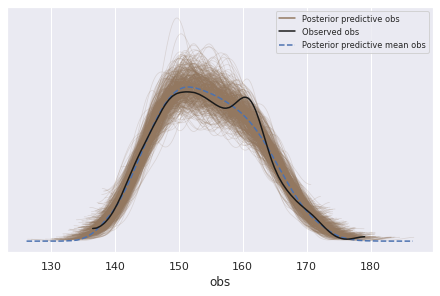

In [369]:
az.plot_ppc(data_ppc,var_names=['obs'])

In [ ]:
mu_pp_male = ppc['alpha'][:,1] + ppc['beta'][:,1] * x[:,None]
mu_pp_female = ppc['alpha'][:,0] + ppc['beta'][:,0] *  x[:,None]
mu_pp_male.shape
mu_pp_female.shape

In [370]:
nr_rows = 500

X = np.linspace(30,65,100)

rows = np.random.choice(result.index,replace=True,size=nr_rows)

sample_mu_f = [result.iloc[rows]['alpha__0'] + result.iloc[rows]['beta__0'] * X[i] for i in range(len(X))]
samples_f = pm.Normal.dist(sample_mu_f,sigma).random()

sample_mu_m = [result.iloc[rows]['alpha__1'] + result.iloc[rows]['beta__1'] * X[i] for i in range(len(X))]
samples_m = pm.Normal.dist(sample_mu_m,sigma).random()

CI_f = np.percentile(samples_f,[5.5,94.5],axis=1)
CI_m = np.percentile(samples_m,[5.5,94.5],axis=1)



array([[149.67333496, 144.70625418, 147.45676597],
       [156.95694386, 154.97970452, 144.55803389],
       [155.79488264, 155.86931414, 163.9800624 ],
       [160.4869762 , 165.98127757, 167.0060136 ],
       [170.29190407, 172.12772492, 176.8689935 ]])

In [ ]:
plt.figure(figsize=(18,12))

ax = plt.gca()

fill_kwargs1_0={'label':'lines 89%',
            'color':'navy',
               'alpha':0.6}

fill_kwargs1_1={'label':'lines 89%',
            'color':'red',
               'alpha':0.6}

fill_kwargs2={'label':'common points 89%',
             'color' : 'orange',
             'alpha' : 0.4}

az.plot_hpd(x,mu_pp_male.T,ax=ax,hdi_prob=0.89,fill_kwargs=fill_kwargs1_0)

az.plot_hpd(x,mu_pp_female.T,ax=ax,hdi_prob=0.89,fill_kwargs=fill_kwargs1_1)


az.plot_hpd(x,ppc['obs'],ax=ax,hdi_prob=0.89,fill_kwargs=fill_kwargs2)

ax.plot(x,mu_pp_male.T.mean(axis=0),'--',color='k',label='mean')

ax.plot(x,mu_pp_female.T.mean(axis=0),'--',color='k',label='mean')


df_female = df.loc[df['male'] == 0]
df_male = df.loc[df['male'] == 1]

ax.scatter(df_male['weight'],df_male['height'],color='b',label='male data')
ax.scatter(df_female['weight'],df_female['height'],color='r',label='female data')

ax.fill_between(X,CI_f[0],CI_f[1],color='pink',alpha=0.5,label='female sample CI')
ax.fill_between(X,CI_m[0],CI_m[1],color='b',alpha=0.5,label='male sample CI')

ax.legend(loc='upper left')